In [1]:
import os
from os.path import join
import sys
import time
from tqdm import tqdm
import random
from collections import defaultdict
REPO = join(os.getenv("REPO"), "ukbb_gwas/bin")
sys.path.insert(0, REPO)

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import seaborn as sns

from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import umap

from dataloader import VariantLoader, EmbeddingLoader, ExomeLoader

In [2]:
DEBUG = False

In [3]:
def debug_only(func):
    def wrapper(*args, **kwargs):
        if DEBUG:
            return func(*args, **kwargs)
    return wrapper

@debug_only
def check_ram():
    import os
    import psutil
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Memory used: {mem_info.rss / (1024 ** 3):.2f} GB")
check_ram()

In [4]:
# temp fix
os.environ["PROCESSED_DATA_EAS"] = "/orange/sai.zhang/khoa/data/UKBB_MOCK"

### Load Variants and Embeddings data from different Populations

In [5]:
populations = ["EUR", "EAS", "AMR", "AFR", "SAS"]

variant_loaders = {}
embedding_loaders = {}
exome_loaders = {}
samples = {}
REF_DB = join(os.getenv("PROCESSED_DATA_EUR"), "processed/ref_exome.csv")
check_ram()
for pop in populations:
    print(f"Loading population: {pop}")
    data_dir = os.getenv(f"PROCESSED_DATA_{pop}")
    
    variant_db = join(data_dir, "processed/sqlite/ukbb_sample_indexed.db")
    embedding_db = join(data_dir, "processed/embeddings/protein_embeddings.h5")
    
    variant_loaders[pop] = VariantLoader(variant_db)
    embedding_loaders[pop] = EmbeddingLoader(embedding_db, metric="mean")
    exome_loaders[pop] = ExomeLoader(variant_loaders[pop], embedding_loaders[pop], REF_DB)
    samples[pop] = variant_loaders[pop].get_all_samples()
    check_ram()
check_ram()

Loading population: EUR


Loading embeddings: 100%|██████████| 24/24 [00:56<00:00,  2.36s/it]


Loading population: EAS


Loading embeddings: 100%|██████████| 24/24 [00:05<00:00,  4.12it/s]


Loading population: AMR


Loading embeddings: 100%|██████████| 24/24 [00:04<00:00,  5.86it/s]


Loading population: AFR


Loading embeddings: 100%|██████████| 24/24 [00:11<00:00,  2.01it/s]


Loading population: SAS


Loading embeddings: 100%|██████████| 24/24 [00:13<00:00,  1.84it/s]


### Construct exome matrix for 25 random individuals in each population

In [6]:
random.seed(1809)
num_sample = 25
exome_matrices = {}
for pop in populations:
    print(f"Get {pop} sample matrix")
    exome_matrices[pop] = exome_loaders[pop].get_sample_matrix(random.sample(samples[pop], k=num_sample))
check_ram()

Get EUR sample matrix
Querying database for sample variants...
Query completed. Found 25 samples with variants.
Sample matrix constructed for 25 samples: [5452935, 5429397, 2735408, 4235981, 5841858, 4468767, 1661211, 2092657, 2913151, 5957733, 2101926, 5264432, 4234181, 2933172, 4043714, 5919898, 4365042, 3096252, 2103593, 4112242, 2287626, 4086209, 2550686, 4427216, 4626727]
Get EAS sample matrix
Querying database for sample variants...
Query completed. Found 25 samples with variants.
Sample matrix constructed for 25 samples: [2865487, 3991097, 2975695, 2897198, 1695604, 2776630, 2089304, 2858351, 5383649, 1674434, 3454358, 4604957, 4229015, 1744120, 3537986, 2780012, 5366404, 2276825, 1002221, 1573335, 3237011, 4691055, 2770833, 3714940, 5456460]
Get AMR sample matrix
Querying database for sample variants...
Query completed. Found 25 samples with variants.
Sample matrix constructed for 25 samples: [1070394, 1844543, 4876233, 2513915, 5394187, 4933668, 3114048, 3291117, 3647805, 5279

### Load reference exome matrix

In [7]:
ref_data = exome_loaders["EUR"].get_ref_embeddings()
check_ram()

### Convert exome matrix to exome matrix diff with reference

In [8]:
exome_matrices_diff = defaultdict(dict)
for pop in populations: 
    print(f"Converting {pop} data")
    for sample, data in exome_matrices[pop].items():
        exome_matrices_diff[pop][sample] = data - ref_data
    check_ram()

Converting EUR data
Converting EAS data
Converting AMR data
Converting AFR data
Converting SAS data


### Flatten matrix and combine for dimension reduction

In [9]:
exome_matrices_diff = defaultdict(dict)
for pop in populations: 
    print(f"Converting {pop} data")
    for sample, data in exome_matrices[pop].items():
        exome_matrices_diff[pop][sample] = data - ref_data
    check_ram()

### Either use matrix itself or diff with reference "person"
# used_matrix = exome_matrices_diff
used_matrix = exome_matrices

all_vectors = []
for pop in populations:
    print(f"Stacking vectors for pop: {pop}")
    for _, vect in used_matrix[pop].items():
        all_vectors.append(vect.flatten())
X = np.stack(all_vectors)  # shape: (n_samples, flattened_features)
check_ram()

Converting EUR data
Converting EAS data
Converting AMR data
Converting AFR data
Converting SAS data
Stacking vectors for pop: EUR
Stacking vectors for pop: EAS
Stacking vectors for pop: AMR
Stacking vectors for pop: AFR
Stacking vectors for pop: SAS


### Keep dimension with high coefficient of variance to reduce number of dimension

In [10]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
cv = np.divide(std, mean, out=np.zeros_like(std), where=mean!=0)
threshold = np.quantile(cv, 0.99)
mask = cv > threshold
X_filtered = X[:, mask]
print(f"Selected {X_filtered.shape[1]} features with CV > {threshold}")

Selected 378767 features with CV > 0.257756327986717


In [11]:
#scale
X_filtered = StandardScaler().fit_transform(X_filtered)
print(X_filtered.shape)

(125, 378767)


### Perform Dimension Reduction and UMAP for visualization

In [12]:
labels = []
for pop in populations:
    labels.extend([pop for i in range(len(exome_matrices_diff[pop]))])
    
print("Running PCA...")
pca = PCA(n_components=40, random_state=42)
X_reduced = pca.fit_transform(X_filtered)

print("Running UMAP...")
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X_reduced)

Running PCA...
Running UMAP...


/blue/sai.zhang/khoang99.stanford/.conda/envs/bioLM/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


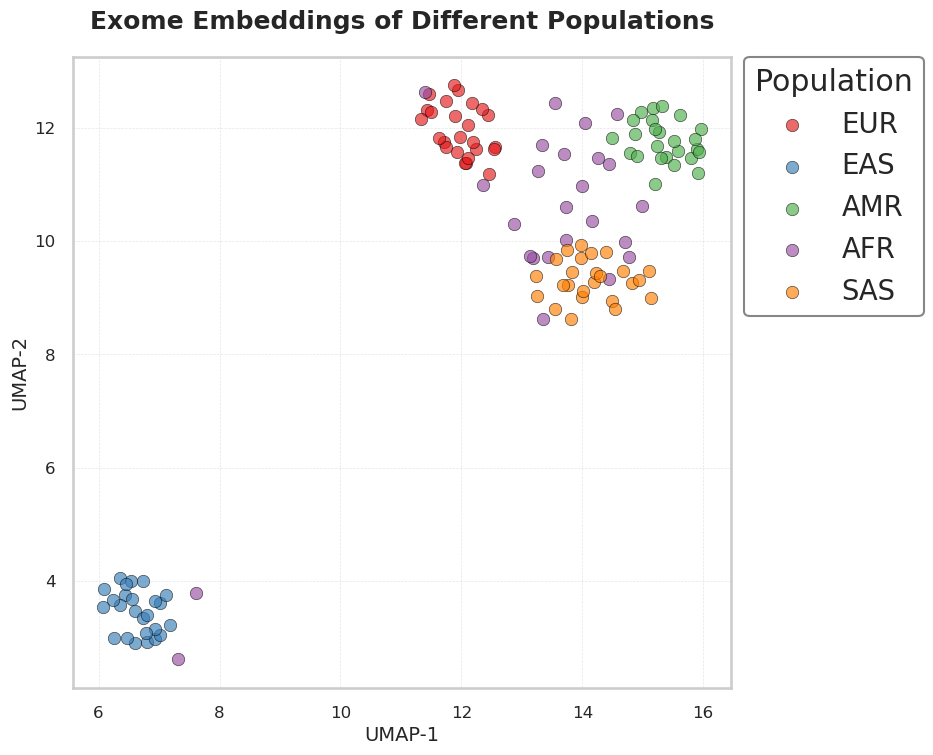

<Figure size 640x480 with 0 Axes>

In [14]:
sns.set(style="whitegrid", context="talk", font_scale=1.2)
palette = sns.color_palette("Set1", n_colors=len(populations))

plt.figure(figsize=(12, 8))
for i, pop in enumerate(populations):
    idx = [j for j, label in enumerate(labels) if label == pop]
    plt.scatter(
        X_umap[idx, 0], X_umap[idx, 1],
        label=pop,
        s=80,
        alpha=0.65,
        edgecolor='black',
        linewidth=0.5,
        color=palette[i]
    )

# Move legend outside the plot
plt.legend(
    title="Population",
    bbox_to_anchor=(1.02, 1), loc="upper left",
    borderaxespad=0.,
    frameon=True, framealpha=0.95, edgecolor='gray'
)

plt.title("Exome Embeddings of Different Populations", fontsize=18, weight='bold', pad=20)
plt.xlabel("UMAP-1", fontsize=14)
plt.ylabel("UMAP-2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
plt.gca().set_facecolor('white')

# Make space on the right for the legend
plt.tight_layout(rect=[0, 0, 0.82, 1])  # leave space on the right
plt.show()
plt.savefig("WeAreAfricans.png")